## Application-specific

In [1]:
import sys

In [2]:
sys.path.append("../config/")
import config

## General

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [4]:
from IPython.display import display, HTML

In [5]:
import pyspark.sql.functions as fn
import pyspark.sql.types as t

# Load from Parquet

In [6]:
df = spark.read.parquet(f'{config.OUTPUT_DATASET}/M20_cards.parquet')

In [7]:
# df.createOrReplaceTempView("cards")

# Descriptive Statistics 

## Total number of cards 

In [8]:
print(f'Total cards int the set: {df.count()}')

Total cards int the set: 987


In [9]:
print(f'Total cards int the set: {df.distinct().count()}')

Total cards int the set: 329


## Types

In [10]:
df_result = df.select("types").distinct()
pd_df = df_result.toPandas()

In [11]:
pd_df

,types
0,Land
1,Sorcery
2,Instant
3,Enchantment
4,Artifact
5,"Artifact,Creature"
6,Planeswalker
7,Creature


In [12]:
card_sum = df.groupBy("types").count().agg(
    fn.sum("count")
)

In [13]:
card_sum = int(card_sum.toPandas().loc[0])

In [14]:
df_result = df.groupBy("types").count()
pd_df = df_result.toPandas()

In [15]:
pd_df

,types,count
0,Land,72
1,Sorcery,81
2,Instant,111
3,Enchantment,63
4,Artifact,51
5,"Artifact,Creature",30
6,Planeswalker,36
7,Creature,543


In [16]:
bcast = sc.broadcast(card_sum)

@fn.udf(returnType=t.FloatType())
def udf_count_to_perc(count):
#     print(count, bcast.value)
    return count / bcast.value

In [17]:
df_result = df.groupBy("types").count().withColumn('perc', fn.format_number(udf_count_to_perc('count'), 2))
pd_df = df_result.toPandas()

In [18]:
pd_df

,types,count,perc
0,Land,72,0.07
1,Sorcery,81,0.08
2,Instant,111,0.11
3,Enchantment,63,0.06
4,Artifact,51,0.05
5,"Artifact,Creature",30,0.03
6,Planeswalker,36,0.04
7,Creature,543,0.55


In [19]:
df_result = df.groupBy("encodedTypes").count()
pd_df = df_result.toPandas()

In [20]:
pd_df

,encodedTypes,count
0,1,30
1,6,36
2,3,63
3,5,72
4,4,111
5,7,81
6,2,543
7,0,51


## Power & Toughness

In [21]:
df_result = df.select("power", "toughness")
df_result = df_result.na.fill(0)
pd_df = df_result.toPandas()

In [22]:
pd_df

,power,toughness
0,0,0
1,0,0
2,0,0
3,6,5
4,6,5
...,...,...
982,7,7
983,7,7
984,3,2
985,3,2


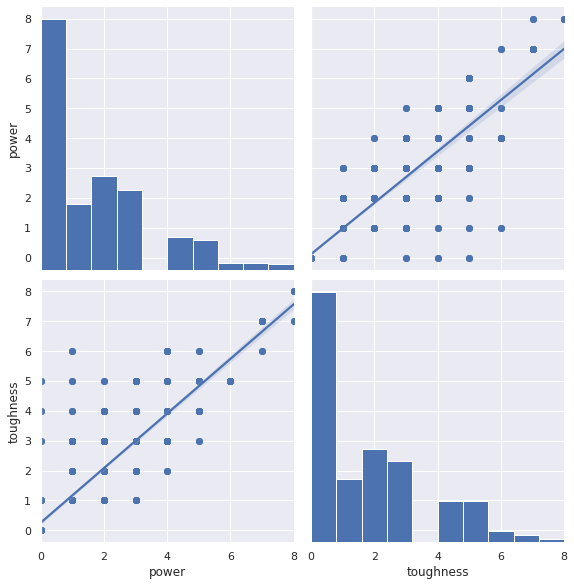

In [23]:
ax = sns.pairplot(pd_df, height=4, kind='reg')

In [24]:
# df_result.corr("power", "toughness", method="pearson")

In [25]:
pd_df.corr(method="spearman")

,power,toughness
power,1.000000,0.915025
toughness,0.915025,1.000000


In [26]:
df.agg({"toughness": "mean"}).collect()

[Row(avg(toughness)=2.93717277486911)]

In [27]:
df_result = df.agg(
    *[fn.min("power").alias("min"),
      fn.max("power").alias("max"),
      fn.format_number(fn.mean("power"), 2).alias("avg")
])
pd_df_power = df_result.toPandas().rename(index={0: 'power'})

In [28]:
df_result = df.agg(
    *[fn.min("toughness").alias("min"),
      fn.max("toughness").alias("max"),
      fn.format_number(fn.mean("toughness"), 2).alias("avg")
])
pd_df_toughness = df_result.toPandas().rename(index={0: 'toughness'})

In [29]:
pd.concat([pd_df_power, pd_df_toughness])

,min,max,avg
power,0,8,2.74
toughness,0,8,2.94


## Length of name 

In [30]:
df_result = df.selectExpr("name").select('name', fn.length("name").alias("length"))
pd_df = df_result.toPandas()

In [31]:
pd_df

,name,length
0,"Chandra, Awakened Inferno",25
1,"Chandra, Awakened Inferno",25
2,"Chandra, Awakened Inferno",25
3,Cavalier of Flame,17
4,Cavalier of Flame,17
...,...,...
982,Vorstclaw,9
983,Vorstclaw,9
984,Barony Vampire,14
985,Barony Vampire,14


In [32]:
df_result = df.selectExpr("name").\
    select("name", fn.split("name", "\s+").alias("tokens")).\
    select("name", "tokens", fn.size("tokens").alias("# tokens"))
pd_df = df_result.toPandas()

In [33]:
pd_df

,name,tokens,# tokens
0,"Chandra, Awakened Inferno","[Chandra,, Awakened, Inferno]",3
1,"Chandra, Awakened Inferno","[Chandra,, Awakened, Inferno]",3
2,"Chandra, Awakened Inferno","[Chandra,, Awakened, Inferno]",3
3,Cavalier of Flame,"[Cavalier, of, Flame]",3
4,Cavalier of Flame,"[Cavalier, of, Flame]",3
...,...,...,...
982,Vorstclaw,[Vorstclaw],1
983,Vorstclaw,[Vorstclaw],1
984,Barony Vampire,"[Barony, Vampire]",2
985,Barony Vampire,"[Barony, Vampire]",2


## Length of text 

In [34]:
df_result = df.selectExpr("name", "originalText").\
    select(fn.col("name").alias("card name"), fn.length("originalText").alias("length")).\
    orderBy(fn.desc("length"))
df_result = df_result.na.fill(value=0, subset=['length'])
pd_df = df_result.toPandas()

In [35]:
pd_df

,card name,length
0,"Ajani, Strength of the Pride",419
1,"Ajani, Strength of the Pride",419
2,"Ajani, Strength of the Pride",419
3,"Chandra, Awakened Inferno",376
4,"Chandra, Awakened Inferno",376
...,...,...
982,Vorstclaw,0
983,Vorstclaw,0
984,Barony Vampire,0
985,Barony Vampire,0


## Mana costs 

In [36]:
df_result = df.select(fn.col("name").alias("card name"),
                      fn.col("convertedManaCost").alias("converted mana cost")).\
                orderBy(fn.desc("converted mana cost"))
pd_df = df_result.toPandas()

In [37]:
pd_df

,card name,converted mana cost
0,"Vilis, Broker of Blood",8
1,"Vilis, Broker of Blood",8
2,"Vilis, Broker of Blood",8
3,"Sephara, Sky's Blade",7
4,"Sephara, Sky's Blade",7
...,...,...
982,Mountain,0
983,Mountain,0
984,Island,0
985,Island,0


In [38]:
max_cmc = pd_df['converted mana cost'].max()

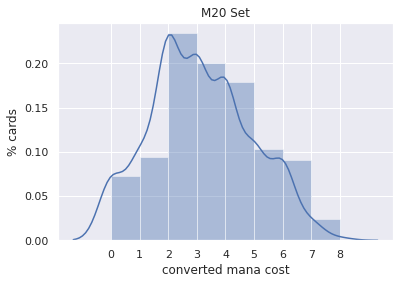

In [39]:
ax = sns.distplot(pd_df['converted mana cost'], bins=range(max_cmc + 1))
_ = ax.set_ylabel('% cards')
_ = ax.set_title('M20 Set')
_ = ax.set_xticks(range(max_cmc + 1))

# Groups 

## By color identity

In [40]:
df_result = df.groupby('colorIdentity').count()
pd_df = df_result.toPandas()

In [41]:
pd_df

,colorIdentity,count
0,"G,W",6
1,"G,R,U",3
2,"B,G,U",3
3,"B,G,W",3
4,"B,G,R,U,W",3
5,B,165
6,"R,W",9
7,"G,R,W",3
8,"G,R",6
9,U,150


In [42]:
df_result = df.groupby('colorIdentity').count().agg(
    fn.sum("count").alias("total number")
).collect()

In [43]:
print(df_result)

[Row(total number=987)]


## From Models, show encoded types

In [44]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel

In [45]:
indexer = StringIndexer.load(f"{config.SPARK_MODELS}/stringindexer_str_types")
model = StringIndexerModel.load(f"{config.SPARK_MODELS}/stringindexer_model_str_types")

In [50]:
# model.stringOrderType

In [52]:
model.labels

['Artifact',
 'Artifact,Creature',
 'Creature',
 'Enchantment',
 'Instant',
 'Land',
 'Planeswalker',
 'Sorcery']

In [53]:
df.agg(
    *[fn.min(df.encodedTypes), fn.max(df.encodedTypes)]
).show()

+-----------------+-----------------+
|min(encodedTypes)|max(encodedTypes)|
+-----------------+-----------------+
|                0|                7|
+-----------------+-----------------+



## Make an overall histogram from encoded types. 

In [54]:
tmp = df.select("encodedTypes").rdd.flatMap(lambda x: x)

In [55]:
tmp.min(), tmp.max()

(0, 7)

In [56]:
hist = df.select("encodedTypes").rdd.flatMap(lambda x: x).histogram(8)

In [59]:
hist

([0.0, 0.875, 1.75, 2.625, 3.5, 4.375, 5.25, 6.125, 7],
 [51, 30, 543, 63, 111, 72, 36, 81])

In [60]:
pd_hist = pd.DataFrame(data=list(zip(*hist)), columns=['bin', 'freq'])

In [61]:
pd_hist['perc'] = pd_hist['freq'] / pd_hist['freq'].sum()

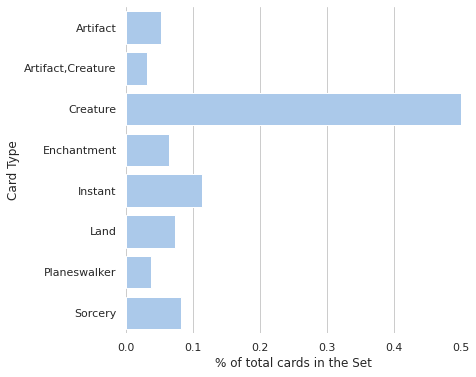

In [67]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 6))

sns.set_color_codes("pastel")
sns.barplot(x="perc", y="bin", data=pd_hist, label="Total", orient='h', color="b")

# ax.set(xlim=(0, 0.4), xlabel="", ylabel="")
ax.set(xlim=(0, 0.5), xlabel="% of total cards in the Set", ylabel="Card Type")
ax.set(yticklabels=model.labels)

sns.despine(left=True, bottom=True)

## By color identity and encoded type

First, let's fetch the distinct color identities

In [68]:
pd_colorIdentities  = df.select("colorIdentity").alias("Color_Identity").distinct().sort("colorIdentity").toPandas()

In [69]:
pd_colorIdentities

,colorIdentity
0,
1,B
2,"B,G"
3,"B,G,R,U,W"
4,"B,G,U"
5,"B,G,W"
6,"B,R"
7,"B,R,W"
8,"B,U"
9,"B,W"


In [70]:
pd_encodedTypes = pd.DataFrame(np.arange(8), columns=['Encoded_Types'])

In [71]:
pd_encodedTypes

,Encoded_Types
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


Create a cartesian product of the color identities and the encoded types.

In [72]:
pd_colorIdentities['key'] = 0
pd_encodedTypes['key'] = 0

In [73]:
pd_cartesian = pd_colorIdentities.merge(pd_encodedTypes, how='outer').drop(columns=['key'])

In [74]:
pd_cartesian = pd_cartesian.rename(columns={'colorIdentity':'Color_Identity'})

In [75]:
pd_cartesian

,Color_Identity,Encoded_Types
0,,0
1,,1
2,,2
3,,3
4,,4
...,...,...
179,W,3
180,W,4
181,W,5
182,W,6


Now, let's create a list which will hold the following: ((color identity, encoded type), 1).

In [76]:
map1 = df.select(["colorIdentity", "encodedTypes"]).rdd.map(
    lambda x: ((x[0], x[1]), 1)
)

map1.take(10)

[(('R', 6), 1),
 (('R', 6), 1),
 (('R', 6), 1),
 (('R', 2), 1),
 (('R', 2), 1),
 (('R', 2), 1),
 (('G', 2), 1),
 (('G', 2), 1),
 (('G', 2), 1),
 (('G,R,U', 2), 1)]

Finally, let's compute the sum of the number of a found encoded types per color identity.

In [77]:
map2 = map1.reduceByKey(lambda a, b: a + b).sortByKey()

In [78]:
map2.take(5)

[(('', 0), 33), (('', 1), 27), (('', 5), 12), (('B', 0), 3), (('B', 2), 99)]

For convience, let's break down the (color identity, encoded type) key into a list of: (color identity, encoded type, sum). 

In [79]:
map3 = map2.map(lambda x: (x[0][0], x[0][1], x[1]))

In [80]:
pd_tab = map3.toDF().toPandas()

In [81]:
pd_tab.columns = ['Color_Identity', 'Encoded_Types', 'Total']

In [82]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total
0,,0,33
1,,1,27
2,,5,12
3,B,0,3
4,B,2,99


Based on the color identity and encoded types, assign a key that corresponds to the cartesian product.

In [83]:
def assign_index(row):
    filter1 = pd_cartesian['Color_Identity'] ==  row['Color_Identity']
    filter2 = pd_cartesian['Encoded_Types'] == row['Encoded_Types']
    
    idx = pd_cartesian.index[filter1 & filter2].tolist()[0]

    return idx

In [84]:
pd_tab['Cart_Index'] = pd_tab.apply (lambda row: assign_index(row), axis=1)

In [85]:
# pd_tab.max()

In [86]:
pd_tab.head(5)

,Color_Identity,Encoded_Types,Total,Cart_Index
0,,0,33,0
1,,1,27,1
2,,5,12,5
3,B,0,3,8
4,B,2,99,10


Find the missing indexes from the cartesian product, and fill-in with "total = 0".

In [87]:
missing_cart_indexes = set(pd_cartesian.index.tolist()) - set(pd_tab.Cart_Index.tolist())

In [88]:
for index in missing_cart_indexes:
    row = pd_cartesian.iloc[index]

    new_df = row.copy()
    new_df['Total'] = 0
    new_df['Cart_Index'] = index
    
    pd_tab = pd_tab.append(new_df)

In [89]:
group_result = pd_tab.groupby('Encoded_Types')

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


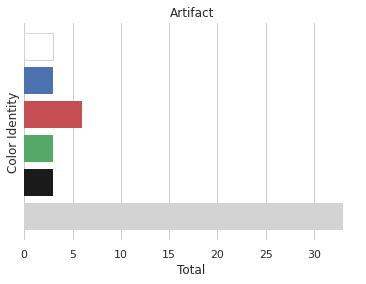

In [90]:
for group_id, (name, indices) in enumerate(group_result.indices.items()):
    group = pd_tab.iloc[indices]
    group.fillna(0)
    
#     print(group)

    f_group = group[group['Total'] > 0]

    labels = f_group['Color_Identity']
    totals = f_group['Total']

    sns.set(style="whitegrid")
    # sns.set()
    sns.set_palette("pastel")

    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        plt.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")

    plt.title(model.labels[group_id])
    plt.xlabel('Total')  
    plt.ylabel('Color Identity')
#     plt.yticks(range(6), labels)
    plt.yticks([])
    sns.despine(left=True, bottom=True)

    plt.show()  
    
    break

### Bars with Gradients

In [91]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

def gradientbars(bars, color):
    grad = np.atleast_2d(np.linspace(0,1,256))
    rgb0 = matplotlib.colors.to_rgba('w')
    rgb1 = matplotlib.colors.to_rgba(color)
    cmap = LinearSegmentedColormap.from_list('tmp', (rgb0, rgb1))

    
    ax = bars[0].axes
    lim = ax.get_xlim() + ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor("none")
        x, y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x, x+w, y, y+h], cmap=cmap,aspect="auto", zorder=0)

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


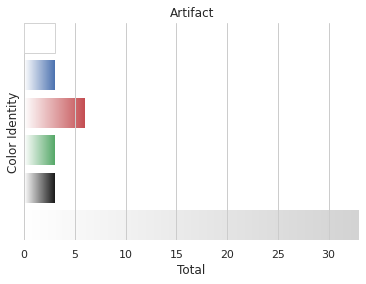

In [92]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set_palette("pastel")


with sns.color_palette("pastel"):
    colors = {
        '': 'lightgray',
        'W': 'w',
        'U': 'b',
        'B': 'k',
        'R': 'r',
        'G': 'g'
    }

    edge_colors = {
        '': '',
        'W': 'lightgray',
        'U': '',
        'B': '',
        'R': '',
        'G': ''
    }

    fig, ax = plt.subplots()

    prev = 0 
    for i in range(len(totals)):
        val = totals.iloc[i]
        label = labels.iloc[i]
        color = colors[label]
        ecolor = edge_colors[label]
        bar = ax.barh(i, val, color=color, linewidth=1.0, alpha=1.0, edgecolor=ecolor)#, hatch="/")
        
        gradientbars(bar, color)

    ax.set_title(model.labels[group_id])
    ax.set_xlabel('Total')  
    ax.set_ylabel('Color Identity')
    #     plt.yticks(range(6), labels)
    ax.set_yticks([])
    ax.axis('auto')
    sns.despine(left=True, bottom=True)

    plt.show()  

### Bars with Gradient and Symbols

In [93]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [94]:
sns.set()

/home/vagrant/venv/lib/python3.6/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


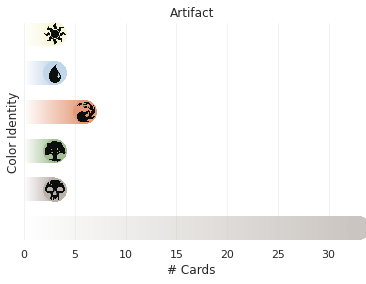

In [95]:
f_group = group[group['Total'] > 0]

labels = f_group['Color_Identity']
totals = f_group['Total']

sns.set(style="whitegrid")
# sns.set()
sns.set_palette("pastel")

colors = {
    '': '#cac5c0ff',
    'W': '#f8f6d8ff',
    'U': '#c1d7e9ff',
    'B': '#bab1abff',
    'R': '#e49977ff',
    'G': '#a3c095ff'
}

edge_colors = {
    '': '',
    'W': '',
    'U': '',
    'B': '',
    'R': '',
    'G': ''
}

images = {
    '': '../assets/Mana/C.png',
    'W': '../assets/Mana/W.png',
    'U': '../assets/Mana/U.png',
    'B': '../assets/Mana/B.png',
    'R': '../assets/Mana/R.png',
    'G': '../assets/Mana/G.png'
}

fig, ax = plt.subplots()

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    color = colors[label]
    ecolor = ''
    image = images[label]
    bar = plt.barh(i, val, color=color, height=0.60, linewidth=0.0, alpha=1.0, edgecolor=ecolor)#, hatch='/')
    
    ab = AnnotationBbox(OffsetImage(plt.imread(image), zoom=0.075), (val, i), frameon=False)
    ax.add_artist(ab)
    
    gradientbars(bar, color)

plt.title(model.labels[group_id])
plt.xlabel('# Cards')  
plt.ylabel('Color Identity')
plt.yticks([])
plt.grid(linewidth=1.0, alpha=0.25)
sns.despine(left=True, bottom=True)
plt.axis('auto')


plt.show()  

###  Cummulative Bar

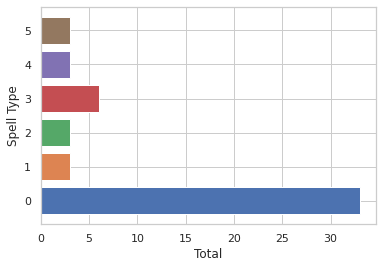

In [96]:
sns.set(style="whitegrid")

prev = 0 
for i in range(len(totals)):
    val = totals.iloc[i]
    label = labels.iloc[i]
    
    plt.barh(i, val)
#     prev = prev + val

plt.xlabel('Total')  
plt.ylabel('Spell Type')

plt.show()  